In [1]:
from collections import OrderedDict
import configparser
from functools import partial
import time
import numpy as np
from shapely import Polygon
import math
from typing import Any
from matplotlib.backend_bases import MouseEvent, MouseButton
from matplotlib.gridspec import GridSpec
from matplotlib import pyplot as plt
import logging
from shapely import Point, Polygon


import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))



logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)


def random_like(array: np.ndarray) -> np.ndarray:
    return np.random.rand(*array.shape)


def get_hd_cue(
    angle: float,
    n_neurons: int,
    max_amplitude: float = 1,
    angular_sigma: float = .1667
) -> np.ndarray:
    # Create a linear space from 0 to 2*pi with n elements
    x = np.linspace(0, 2 * np.pi, n_neurons, endpoint=False)

    # Ensure the angle is within the range [0, 2*pi]
    angle = angle % (2 * np.pi)

    # Calculate the distance on the ring between each point and the peak angle
    # This takes into account the wrap-around effect
    distance = np.minimum(np.abs(x - angle), 2 * np.pi - np.abs(x - angle))

    # Create a Gaussian distribution centered at the specified angle with wrap-around
    gaussian = max_amplitude * np.exp(-(distance**2) / (2 * angular_sigma**2))

    return gaussian


def get_gaussian_kernel(
    n_neurons: int,
    sigma: float = .05,
    center: float = .5,
    amplitude: float = 1.
) -> np.ndarray:
    # x = np.linspace(0, 1, n_neurons, endpoint=False)
    # distance = np.minimum(np.abs(x - center), 2 * np.pi - np.abs(x - center))
    # gaussian = amplitude*np.exp(-(distance**2) / (2 * sigma**2))

    return get_hd_cue(
        center*2*np.pi,
        n_neurons,
        amplitude,
        angular_sigma=sigma*2*np.pi
    )


In [2]:
from typing import Mapping

from bbtoolkit.dynamics.callbacks import BaseCallback


class HDCallback(BaseCallback):
    def __init__(
        self,
        init_timesteps: int = 30,
        hd_cue_scale: float = 60,
    ):
        super().__init__()
        self.init_timesteps = init_timesteps
        self.hd_cue_scale = hd_cue_scale
        self.total_steps = None
        self.mode = None

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):

        self.requires = [
            'dynamics_params',  # Dynamic parameters including dt, mode, and step.
            'tc_gen',  # Transformation circuit generator for HD activity.
            'movement_params',  # Movement parameters including position and direction.
            'mental_movement_params',  # Mental movement parameters for cognitive navigation.
            'hd_cue',  # HD cue array for external directional cues.
            'k_ratio',  # Ratio of excitation/inhibition for HD cells.
            'activity',  # Neural activity levels.
            'connectivity',  # Connectivity matrices between neural populations.
            'weights',  # Synaptic weights between neurons.
            'rates'  # Firing rates of neurons.
        ]

        cache['hd_cue'] = np.zeros(len(cache['weights'].hd.to.hd))
        super().set_cache(cache, on_repeat)
        self.dt = self.dynamics_params['dt']

    def on_step_begin(self, step: int):
        if self.mode != self.dynamics_params['mode']:
            if self.dynamics_params['mode'] not in self.no_cue_reset_modes:
                self.total_steps = self.init_timesteps

            self.mode = self.dynamics_params['mode']

        if self.total_steps == self.init_timesteps:
            logging.debug('HD CUE INITIATED')


        if self.total_steps != 0:
            self.total_steps -= 1
            self.hd_cue += self.hd_cue_scale*self.tc_gen.get_hd_activity(np.array([self.movement_params.direction]))
        else:
            if not np.all(self.hd_cue == 0):
                logging.debug('HD CUE REMOVED')
                self.hd_cue *= 0

        rot_weights = None
        match self.dynamics_params['mode']:
            case 'bottom-up':
                params = self.movement_params
                target = self.movement_params.move_target if self.movement_params.move_target is not None else self.movement_params.rotate_target
                position = self.movement_params.position
                direction = self.movement_params.direction
            case 'top-down':
                params = self.mental_movement_params
                target = self.mental_movement_params.move_target if self.mental_movement_params.move_target is not None else self.mental_movement_params.rotate_target
                position = self.mental_movement_params.position
                direction = self.mental_movement_params.direction
            case 'recall':
                params, target, position, direction = None, None, None, None

        if target is not None:
            angle_to_target = math.atan2(
                target[1] - position[1],
                target[0] - position[0]
            ) % (2*np.pi)

            diff = angle_to_target - direction
            if diff > np.pi:
                diff -= 2*np.pi
            elif diff < -np.pi:
                diff += 2*np.pi

            if diff < 0:
                rot_weights = self.weights.rot.to.rot.T
            elif diff > 0:
                rot_weights = self.weights.rot.to.rot
            elif np.isclose(angle_to_target, direction):
                rot_weights = None

        if rot_weights is None:
            rot_weights = np.zeros_like(self.weights.rot.to.rot)

        self.k_ratio.hd = -self.activity.hd +\
            (self.connectivity.hd.to.hd['phi']*self.weights.hd.to.hd@self.rates.hd) +\
            self.hd_cue[:, np.newaxis] +\
            (self.connectivity.rot.to.rot['phi']*rot_weights@self.rates.hd)

        if self.dynamics_params['mode'] in ('recall', 'top-down'):
            self.k_ratio.hd += self.connectivity.opr.to.hd['phi'] * self.weights.opr.to.hd@self.rates.opr

        self.activity.hd += self.dt/self.connectivity.hd.to.hd['tau']*self.k_ratio.hd
        self.rates.hd = 1/(1 + np.exp(-2*self.connectivity.hd.to.hd['beta']*(self.activity.hd - self.connectivity.hd.to.hd['alpha'])))

        # HD estimation
        if self.total_steps == 0 and self.dynamics_params['mode'] != 'recall':
            popmax = np.where(self.rates.hd == np.max(self.rates.hd))[0][0]
            hd_estim = popmax*2*np.pi/(len(self.rates.hd) - 1) % (2*np.pi)

            params.direction = hd_estim

In [3]:
from bbtoolkit.dynamics.callbacks.viz import ArtistCallback


class TimerPlotter(ArtistCallback):
    def __init__(self, coords: tuple[float, float]):
        super().__init__()
        self.coords = coords

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        cache['time_ax'] = cache.fig.add_subplot(cache.gc[:1, 1])
        self.requires = ['time_ax', 'dynamics_params']
        super().set_cache(cache, on_repeat)

    def plot(self):
        self.time_ax.text(*self.coords, f'Time: {(self.dynamics_params.step)*self.dynamics_params.dt : .2f} s')

    def on_plot(self):
        self.plot()

    def on_clean(self):
        self.time_ax.clear()
        self.time_ax.set_axis_off()

In [4]:
class PolarCirclePlotter(ArtistCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        cache['main_ax'] = cache.fig.add_subplot(cache.gc[:6, :], projection='polar')
        self.requires = [
            'main_ax',
            'movement_params',
            'fig'
        ]
        super().set_cache(cache, on_repeat)

    def on_plot(self):
        if self.movement_params.rotate_target is not None:
            self.main_ax.plot(
                [
                    self.movement_params.rotate_target,
                    self.movement_params.rotate_target
                ],
                [0, 1],
                marker='o'
            )
        if self.movement_params.direction is not None:
            self.main_ax.plot(
                [
                    self.movement_params.direction,
                    self.movement_params.direction
                ],
                [0, 1],
                marker='o',
                color='red'
            )

    def on_clean(self):
        self.main_ax.clear()

In [5]:

class MouseEventCallback(ArtistCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'fig',
            'dynamics_params',
            'movement_params',
            'click_params',
            'main_ax'
        ]
        super().set_cache(cache, on_repeat)
        self.fig.canvas.mpl_connect('button_press_event', self.on_click)

    def on_click(self, event: MouseEvent):

        if event.inaxes is self.main_ax:

            self.click_params.xy_data = (event.xdata, event.ydata)
            self.movement_params.rotate_target = event.xdata

    def on_copy(self):
        self.fig.canvas.mpl_connect('button_press_event', self.on_click)

    def on_load(self):
        self.on_copy()

2024-06-07 15:49:27 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-06-07 15:49:27 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-06-07 15:49:27 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-06-07 15:49:27 - DEBUG - findfont: score(FontEntry(fname='/home/user/Projects/SpatialMemory/venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 0.05
2024-06-07 15:49:27 - DEBUG - findfont: score(FontEntry(fname='/home/user/Projects/SpatialMemory/venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2024-06-07 15:49:27 - DEBUG - findfont: score(FontEntry(fname='/home/user/Proje

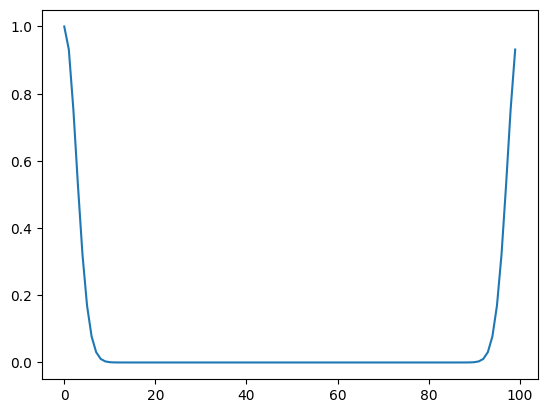

In [6]:
import numpy as np

def get_hd_cue(
    angle: float,
    n_neurons: int,
    max_amplitude: float = 1,
    angular_sigma: float = .1667
) -> np.ndarray:
    # Create a linear space from 0 to 2*pi with n elements
    x = np.linspace(0, 2 * np.pi, n_neurons, endpoint=False)

    # Ensure the angle is within the range [0, 2*pi]
    angle = angle % (2 * np.pi)

    # Calculate the distance on the ring between each point and the peak angle
    # This takes into account the wrap-around effect
    distance = np.minimum(np.abs(x - angle), 2 * np.pi - np.abs(x - angle))

    # Create a Gaussian distribution centered at the specified angle with wrap-around
    gaussian = max_amplitude * np.exp(-(distance**2) / (2 * angular_sigma**2))

    return gaussian


# Example usage
angle = 0  # 45 degrees in radians
n = 100
amplitude = 1
sigma = 0.1
gaussian_vector = get_hd_cue(angle, n)
plt.plot(gaussian_vector)

In [7]:
import numpy as np

def should_rotate_clockwise(phi1: float, phi2: float) -> bool:
    # Normalize angles to be within 0 to 2*pi radians
    phi1 = phi1 % (2 * np.pi)
    phi2 = phi2 % (2 * np.pi)

    # Calculate the difference in angles
    diff = phi2 - phi1

    # Normalize the difference to be within -pi to pi radians
    # This determines the shortest rotation direction
    if diff > np.pi:
        diff -= 2 * np.pi
    elif diff < -np.pi:
        diff += 2 * np.pi

    # If diff is positive, the shortest way is clockwise
    # If diff is negative, the shortest way is counterclockwise
    if np.isclose(diff, 0):
        return None

    return diff > 0

In [8]:
from bbtoolkit.environment import Environment
from bbtoolkit.models.bb.neural_generators import TCGenerator
from bbtoolkit.utils.datautils.configparser import EvalConfigParser


hd_config_path = '../cfg/cells/hd_cells.ini'
hd_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
hd_config.read(hd_config_path)

mtl_config_path = '../cfg/cells/mtl_cells.ini'
mtl_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
mtl_config.read(mtl_config_path)

tr_config_path = '../cfg/cells/transformation_circuit.ini'
tr_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
tr_config.read(tr_config_path)

env_cfg = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
env_cfg.read('../cfg/envs/squared_room.ini')

space_cfg = mtl_config['Space']
h_res = space_cfg.eval('res')
r_max = space_cfg.eval('r_max')

mtl_grid_cfg = mtl_config['PolarGrid']
n_radial_points = mtl_grid_cfg.eval('n_radial_points')
polar_dist_res = mtl_grid_cfg.eval('polar_dist_res')
polar_ang_res = mtl_grid_cfg.eval('polar_ang_res', locals={'pi': np.pi})
h_sig = mtl_grid_cfg.eval('sigma_hill')

tr_space_cfg = tr_config['Space']
tr_res = tr_space_cfg.eval('tr_res', locals={'pi': np.pi})
res = tr_space_cfg.eval('res')

n_steps = tr_config['Training'].eval('n_steps')

hd_neurons_cfg = hd_config['Neurons']
sigma_angular = hd_neurons_cfg.eval('sigma', locals={'pi': np.pi})
n_hd = hd_neurons_cfg.eval('n_neurons')


training_rect_cfg = env_cfg['TrainingRectangle']
max_train_x = training_rect_cfg.eval('max_train_x')
min_train_x = training_rect_cfg.eval('min_train_x')
max_train_y = training_rect_cfg.eval('max_train_y')
min_train_y = training_rect_cfg.eval('min_train_y')

# env = Environment.load('../../../Downloads/Telegram Desktop/doellerlab_env (2).pkl')
env = Environment.load('../data/envs/inserted_wall_environment.pkl')
# env = Environment.load('../data/envs/square_environment.pkl')

tc_gen = TCGenerator(
    n_hd,
    tr_res,
    res,
    r_max,
    polar_dist_res,
    n_radial_points,
    polar_ang_res,
    sigma_angular
)

In [9]:
def generate_index_shapes(shape: int) -> list[tuple[int, ...]]:
    return [(1,) * i + (shape[i],) + (1,) * (len(shape) - i - 1) for i in range(len(shape))]


def generate_tile_shapes(shape: tuple[int, ...]) -> tuple[tuple[int, ...]]:
    return tuple(tuple(1 if j == i else shape[j] for j in range(len(shape))) for i in range(len(shape)))


def create_index_matrix(shape: tuple[int, ...]) -> tuple[np.ndarray, ...]:
    # Calculate the center indices
    center = [dim//2 for dim in shape]
    indices = [
        np.arange(dim).reshape(*index_shape) - center
        for dim, center, index_shape in zip(shape, center, generate_index_shapes(shape))
    ]

    return tuple(
        np.tile(
            index, tile_shape
        )
        for index, tile_shape in zip(indices, generate_tile_shapes(shape))
    )


def select_data(data: np.ndarray, indices: np.ndarray) -> np.ndarray:
    # Check dimensions
    if isinstance(indices, (tuple, list)):
        indices_ndim = len(indices)
        indices = [*indices]
    else:
        indices_ndim = indices.ndim
        indices = [indices]

    if indices_ndim >= data.ndim:
        # Directly use indices for selection
        return data[*indices]
    else:
        # Prepare a tuple for advanced indexing
        idx = [slice(None)] * (data.ndim - indices_ndim) + indices
        return data[tuple(idx)]


def wrap_indices(indices: tuple[int, ...], shape: tuple[int, ...]) -> tuple[int, ...]:
    if len(indices) != len(shape):
        raise ValueError('Indices and shape must have the same length')
    return tuple((((i % s) + s) % s for i, s in zip(indices, shape)))

In [10]:
class WrapperIndexer:
    def __init__(self, shape: tuple[int, ...]):
        self.shape = shape

    def __getitem__(self, item: tuple[int, ...]):
        return wrap_indices(item, self.shape)

class AttractorIndexer:
    def __init__(self, shape: tuple[int, ...]):
        self.shape = shape
        self.indexer = WrapperIndexer(shape)

    def __getitem__(self, item: tuple[int, ...]):
        return np.ix_(*[
            (np.arange(dim) - shift) % dim
            for shift, dim in zip(self.indexer[item], self.shape)
        ])

class InverseAttractorIndexer:
    def __init__(self, shape: tuple[int, ...]):
        self.shape = shape
        self.indexer = WrapperIndexer(shape)  # Assuming WrapperIndexer is defined elsewhere

    def __getitem__(self, item: tuple[int, ...]):
        return np.ix_(*[
            (np.arange(dim)) % dim
            for dim in self.shape
        ])



In [11]:
class RingAttractorState:
    def __init__(
        self,
        kernels: tuple[np.ndarray, ...],
        weights: tuple[np.ndarray, ...],
        indexer: AttractorIndexer,
        inplace: bool = False
    ):
        self.kernels = kernels
        weights = list(weights)
        weights = [weights[-1]] + weights[:-1]
        self.weights = weights
        self.indexer = indexer
        self.inplace = inplace

    @property
    def shape(self) -> tuple[int, ...]:
        return self.kernels[0].shape

    @property
    def ndim(self) -> int:
        return self.kernels[0].ndim

    def __len__(self) -> int:
        return len(self.kernels)

    def __getitem__(self, indices: np.ndarray) -> tuple[np.ndarray, ...]:
        indices = wrap_indices(indices, self.shape)
        kernels = list(self.kernels)

        return tuple(
            select_data(
                weights, self.indexer[indices]
            )*kernel[*indices]
            for weights, kernel in zip(self.weights, kernels)
        )

    def __matmul__(self, other: tuple[np.ndarray, ...]) -> tuple[np.ndarray, ...]:
        if not self.inplace:
            other = tuple(inst.copy() for inst in other)

        for indices in zip(*np.nonzero(np.add(*self.kernels))):
            updates = self[indices]
            other = list(weight + update for weight, update in zip(other, updates))

        return other

    def values(self) -> np.ndarray:
        return self@tuple(np.zeros_like(weight) for weight in self.weights)


class RingAttractor:
    def __init__(
        self,
        kernels: tuple[np.ndarray, ...],
        inplace: bool = False
    ):
        self.kernels = kernels
        self.kernels_shifted = tuple(kernel[create_index_matrix(kernel.shape)] for kernel in kernels)
        self.indexer = AttractorIndexer(self.shape)
        self.inplace = inplace

    @property
    def shape(self) -> tuple[int, ...]:
        return self.kernels[0].shape

    @property
    def ndim(self) -> int:
        return self.kernels[0].ndim

    def __len__(self) -> int:
        return len(self.kernels)

    def __call__(self, weights: tuple[np.ndarray, ...]) -> RingAttractorState:
        if not self.inplace:
            weights = tuple(weight.copy() for weight in weights)
        return RingAttractorState(self.kernels_shifted, weights, self.indexer, self.inplace)

    def get_weights(self) -> tuple[np.ndarray, ...]:
        inverse_indexer = InverseAttractorIndexer(self.shape)

        weights_matrices = [np.zeros(list(self.shape) + list(self.shape)) for _ in range(len(self.kernels))]
        state = self([np.ones(self.shape) for _ in range(len(self.kernels))])

        for indices in zip(*np.nonzero(np.add(*self.kernels_shifted))):
            state_matrices = state[indices]

            for i in range(len(weights_matrices)):
                weights_matrices[i][*inverse_indexer[indices], *state.indexer[indices]] = state_matrices[i]

        return tuple(weights_matrices)

In [12]:
attr = RingAttractor((
    get_gaussian_kernel(
        100,
        center=0.5,
        sigma=0.05
    )[None, :],
    (get_gaussian_kernel(
        100,
        center=0.,
        sigma=0.05
    ) - .5)[None, :]
))
w1, w2 = attr.get_weights()
r1, r2 = np.random.random(attr.kernels[0].shape).T, np.random.random(attr.kernels[1].shape).T
# res1 = (weights[0, :, 0, :]@w.T).T
# res2 = attr(w).values()

# np.all(np.isclose(res1, res2))

2024-06-07 15:49:29 - DEBUG - Loaded backend inline version unknown.


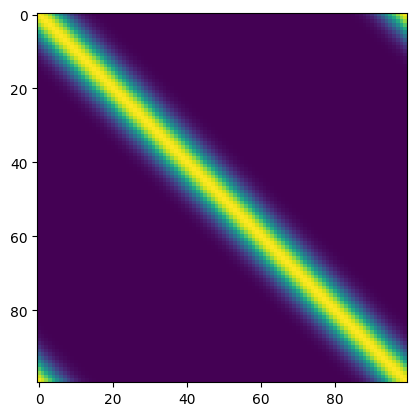

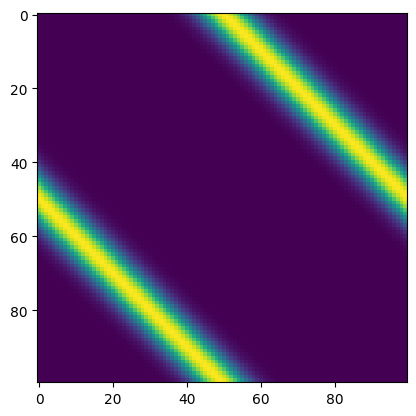

In [13]:
%matplotlib inline
plt.imshow(w1[0, :, 0, :])
plt.show()
plt.imshow(w2[0, :, 0, :])
plt.show()

In [14]:
(w2[0, :, 0]@r1).T

array([[-17.77189754, -17.75982528, -17.73932144, -17.71343957,
        -17.68582102, -17.6595064 , -17.63619861, -17.61617428,
        -17.59878592, -17.58329345, -17.56968178, -17.5591734 ,
        -17.55429079, -17.55849054, -17.57551392, -17.60864473,
        -17.66004226, -17.73025816, -17.81798725, -17.92006016,
        -18.03166067, -18.14672819, -18.25848093, -18.3599731 ,
        -18.44459484, -18.50644892, -18.5405899 , -18.54317194,
        -18.51159263, -18.44472189, -18.34326142, -18.21020455,
        -18.05128435, -17.87523748, -17.69369622, -17.52056264,
        -17.37081637, -17.25884527, -17.19653584, -17.19147825,
        -17.24568527, -17.35516826, -17.51055121, -17.69866927,
        -17.90485025, -18.11538883, -18.31965368, -18.51134593,
        -18.68863624, -18.85319453, -19.00841119, -19.15731291,
        -19.30074238, -19.43628114, -19.55817704, -19.65825956,
        -19.72757184, -19.75828973, -19.74547087, -19.68826744,
        -19.59039647, -19.45983046, -19.

In [15]:
attr((r1.T, r2.T)).values()[1]

array([[-17.77189754, -17.75982528, -17.73932144, -17.71343957,
        -17.68582102, -17.6595064 , -17.63619861, -17.61617428,
        -17.59878592, -17.58329345, -17.56968178, -17.5591734 ,
        -17.55429079, -17.55849054, -17.57551392, -17.60864473,
        -17.66004226, -17.73025816, -17.81798725, -17.92006016,
        -18.03166067, -18.14672819, -18.25848093, -18.3599731 ,
        -18.44459484, -18.50644892, -18.5405899 , -18.54317194,
        -18.51159263, -18.44472189, -18.34326142, -18.21020455,
        -18.05128435, -17.87523748, -17.69369622, -17.52056264,
        -17.37081637, -17.25884527, -17.19653584, -17.19147825,
        -17.24568527, -17.35516826, -17.51055121, -17.69866927,
        -17.90485025, -18.11538883, -18.31965368, -18.51134593,
        -18.68863624, -18.85319453, -19.00841119, -19.15731291,
        -19.30074238, -19.43628114, -19.55817704, -19.65825956,
        -19.72757184, -19.75828973, -19.74547087, -19.68826744,
        -19.59039647, -19.45983046, -19.

In [16]:
(w2[0, :, 0]@r2).T

array([[-20.23572845, -20.20213682, -20.16153496, -20.1109711 ,
        -20.04822696, -19.97246187, -19.88444655, -19.78627028,
        -19.680632  , -19.57000993, -19.45606543, -19.33954515,
        -19.22073656, -19.10029114, -18.98005773, -18.86353937,
        -18.75571516, -18.66220325, -18.58798707, -18.5360881 ,
        -18.50658767, -18.49628182, -18.49905845, -18.50689435,
        -18.51124632, -18.50457108, -18.48172902, -18.44106375,
        -18.38497672, -18.31984294, -18.25517461, -18.20206612,
        -18.17113946, -18.17039957, -18.20351921, -18.26902855,
        -18.36066969, -18.46884633, -18.58276895, -18.69268987,
        -18.79161849, -18.87610339, -18.94598415, -19.00333101,
        -19.05099654, -19.09124823, -19.12485171, -19.15079783,
        -19.16668805, -19.16966015, -19.1576556 , -19.13077778,
        -19.09244516, -19.05000948, -19.0145244 , -18.99946066,
        -19.01839188, -19.08198542, -19.1949321 , -19.35361772,
        -19.54528169, -19.74910373, -19.

In [17]:
def create_ricker_matrix(m, n, a=None):
    # Create an m x n matrix
    matrix = np.zeros((m, n))

    if a is None:
        a = min(m, n) // 10

    # Calculate the center of the matrix
    center_x, center_y = m // 2, n // 2

    # Iterate over the matrix to apply the Ricker wavelet function
    for i in range(m):
        for j in range(n):
            # Calculate distances from the center
            x = i - center_x
            y = j - center_y
            # Calculate the Ricker wavelet value
            factor = (x**2 + y**2) / a**2
            matrix[i, j] = (1 - factor) * np.exp(-factor / 2)

    return matrix



def create_gaussian_matrix(m, n, sigma = None):
    # Create an m x n matrix
    matrix = np.zeros((m, n))

    if sigma is None:
        sigma = min(m, n) // 10

    # Calculate the center of the matrix
    center_x, center_y = m // 2, n // 2

    # Iterate over the matrix to apply the Gaussian function
    for i in range(m):
        for j in range(n):
            # Calculate the Gaussian value
            matrix[i, j] = np.exp(-((i - center_x) ** 2 + (j - center_y) ** 2) / (2 * sigma ** 2))

    return matrix

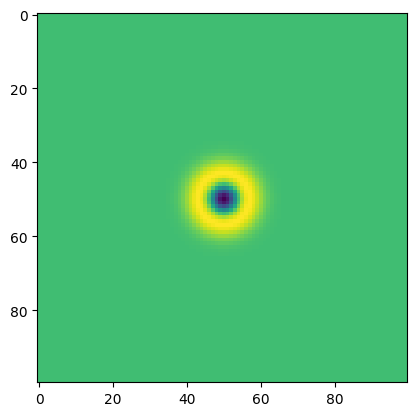

In [18]:
plt.imshow(-create_ricker_matrix(100, 100, 4))

In [19]:
w1, w2 = (np.random.rand(1, 1, 100, 100), np.random.rand(1, 1, 100, 100))

2024-06-07 15:49:30 - DEBUG - Loaded backend inline version unknown.
2024-06-07 15:49:30 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7dffc870d250>
2024-06-07 15:49:30 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7dfff47892b0>


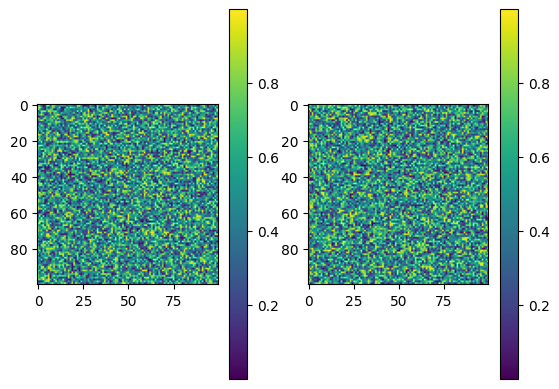

2024-06-07 15:49:32 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7dffc77b5220>
2024-06-07 15:49:32 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7dffc870d610>


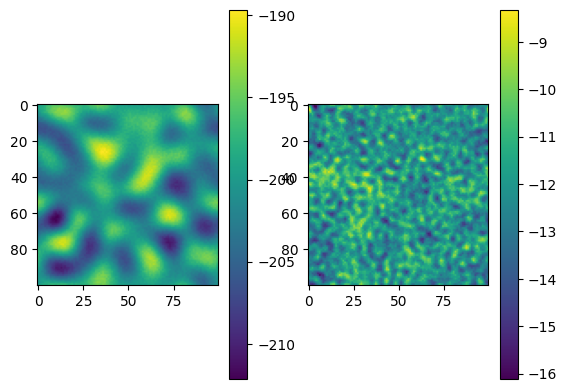

In [20]:
%matplotlib inline



# all_data = np.ones((6, 6))
# all_data = (np.random.rand(1, 1, 100, 100), np.random.rand(1, 1, 100, 100))
all_data = (w1.copy(), w2.copy())
# all_data = (np.ones_like(w1), -np.ones_like(w2))
# w = np.random.rand(1, 1, 100, 100)
# all_data = (w.copy(), -w.copy())

fig, (ax1, ax2) = plt.subplots(1, 2)

c = ax1.imshow(all_data[0][0, 0])
plt.colorbar(c)
c = ax2.imshow(all_data[1][0, 0])
plt.colorbar(c)
plt.show()

attr = RingAttractor((
    create_ricker_matrix(*all_data[0].shape[-2:], 8),
    # create_gaussian_matrix(*all_data[0].shape[-2:], 4),
    create_ricker_matrix(*all_data[0].shape[-2:], 2),
))
state = attr(all_data)

all_data = state@all_data

fig, (ax1, ax2) = plt.subplots(1, 2)

c = ax1.imshow(all_data[0][0, 0])
plt.colorbar(c)
c = ax2.imshow(all_data[1][0, 0])
plt.colorbar(c)
plt.show()

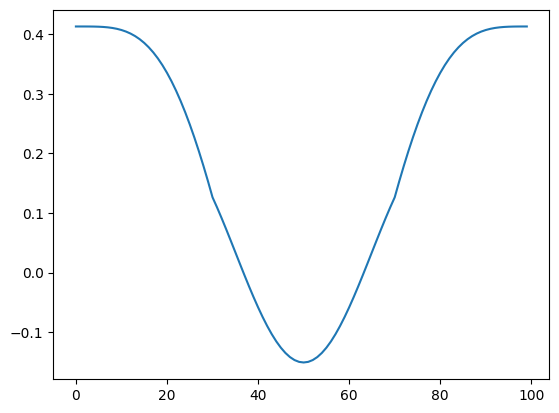

In [21]:
def get_gaussian_kernel(
    n_neurons: int,
    sigma: float = .05,
    center: float = .5,
    amplitude: float = 1.
) -> np.ndarray:
    # x = np.linspace(0, 1, n_neurons, endpoint=False)
    # distance = np.minimum(np.abs(x - center), 2 * np.pi - np.abs(x - center))
    # gaussian = amplitude*np.exp(-(distance**2) / (2 * sigma**2))

    return get_hd_cue(
        center*2*np.pi,
        n_neurons,
        amplitude,
        angular_sigma=sigma*2*np.pi
    )

plt.plot(
    get_gaussian_kernel(
        100,
        center=0.2,
        sigma=0.2
    ) - .4 + get_gaussian_kernel(
        100,
        center=0.8,
        sigma=0.2
    ) - .4
)

2024-06-07 15:49:32 - DEBUG - Loaded backend inline version unknown.


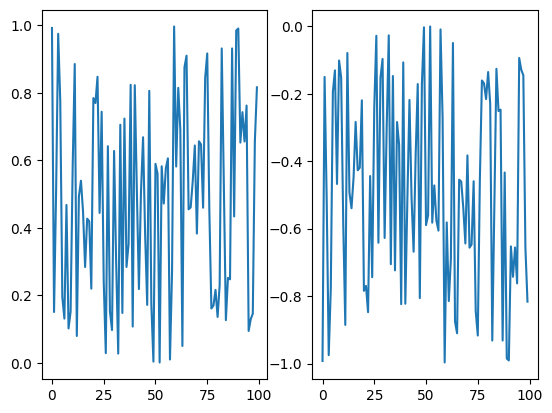

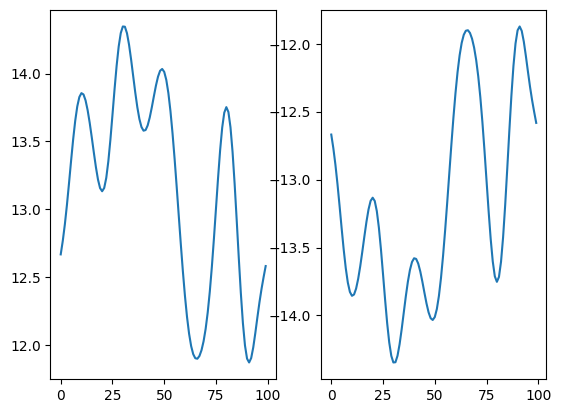

In [22]:
%matplotlib inline

# w1, w2 = (np.random.rand(100), np.random.rand(100))
w1 = np.random.rand(1, 100)
w2 = -w1.copy()

# all_data = np.ones((6, 6))
# all_data = (np.random.rand(1, 1, 100, 100), np.random.rand(1, 1, 100, 100))
all_data = (w1.copy(), w2.copy())
# all_data = (np.ones_like(w1), -np.ones_like(w2))
# w = np.random.rand(1, 1, 100, 100)
# all_data = (w.copy(), -w.copy())

fig, (ax1, ax2) = plt.subplots(1, 2)

c = ax1.plot(all_data[0].T)
# plt.colorbar(c)
c = ax2.plot(all_data[1].T)
# plt.colorbar(c)
plt.show()

attr = RingAttractor((
    get_gaussian_kernel(
        100
    ) - .4,
    (get_gaussian_kernel(
        100
    ) - .4),
))
state = attr(all_data)

all_data = state.values()#@all_data

fig, (ax1, ax2) = plt.subplots(1, 2)

c = ax1.plot(all_data[0][0])
# plt.colorbar(c)
c = ax2.plot(all_data[1][0])
# plt.colorbar(c)
plt.show()

In [23]:
from bbtoolkit.models.bb.utils import activity2rate, connectivity_config2dict
from bbtoolkit.structures.tensorgroups import NamedTensor, TensorGroup, dict2directed_tensor
from bbtoolkit.utils.datautils.configparser import EvalConfigParser
from bbtoolkit.structures.tensorgroups import DirectedTensorGroup
from bbtoolkit.structures.tensorgroups import DirectedTensor, DirectedTensorGroup

weights = DirectedTensorGroup.load('../data/weights/hd_weights_square.pkl')
n_hd_neurons = len(weights.hd.to.hd)

activity = TensorGroup(
    NamedTensor('hd_ring1', np.zeros((n_hd_neurons, 1))),
    NamedTensor('hd_ring2', np.zeros((n_hd_neurons, 1))),
)

config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
config.read('../cfg/connectivity/main.ini')

configdict = connectivity_config2dict(config)
connections = dict2directed_tensor(configdict)
connectivity = DirectedTensorGroup(*connections)

connectivity.add_tensor(
    DirectedTensor(
        from_='hd_ring1',
        to='hd_ring1',
        weights=connectivity.hd.to.hd
    )
)
connectivity.add_tensor(
    DirectedTensor(
        from_='hd_ring2',
        to='hd_ring2',
        weights=connectivity.hd.to.hd
    )
)

weights = weights.operation_with(
    connectivity,
    lambda a, b: a - b.get('inhibitory_phi', 0),
    on_missing_weights='ignore',
    on_missing_sources='ignore'
)

rates = activity2rate(activity, connectivity)

k_ratio = TensorGroup(
    NamedTensor('hd_ring1', np.zeros((n_hd_neurons, 1))),
    NamedTensor('hd_ring2', np.zeros((n_hd_neurons, 1))),
)

In [24]:
get_hd_cue

<function __main__.get_hd_cue(angle: float, n_neurons: int, max_amplitude: float = 1, angular_sigma: float = 0.1667) -> numpy.ndarray>

In [25]:
get_hd_cue

<function __main__.get_hd_cue(angle: float, n_neurons: int, max_amplitude: float = 1, angular_sigma: float = 0.1667) -> numpy.ndarray>

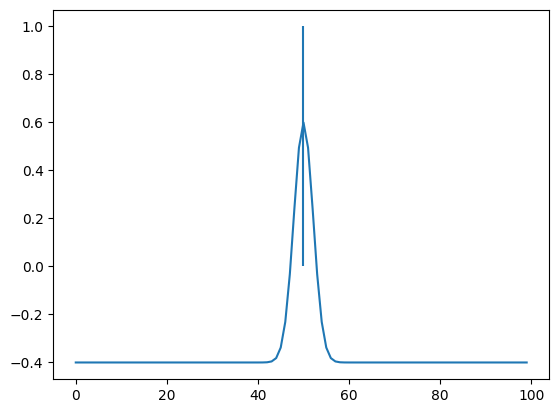

In [26]:
plt.plot(weights.hd.to.hd[weights.hd.to.hd.shape[0]//2])
plt.vlines(50, 0, 1)

2024-06-07 15:49:33 - DEBUG - Loaded backend inline version unknown.


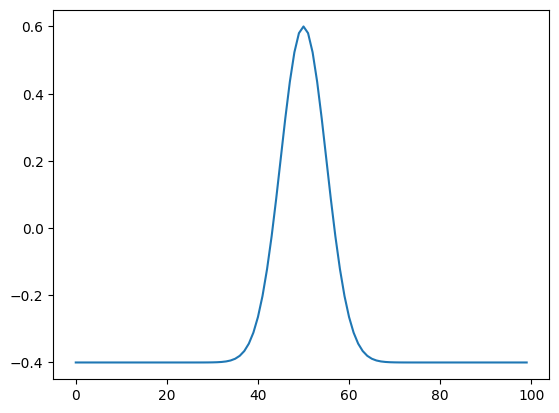

In [27]:
%matplotlib inline

def get_gaussian_kernel(
    n_neurons: int,
    sigma: float = .05,
    center: float = .5,
    amplitude: float = 1.
) -> np.ndarray:
    # x = np.linspace(0, 1, n_neurons, endpoint=False)
    # distance = np.minimum(np.abs(x - center), 2 * np.pi - np.abs(x - center))
    # gaussian = amplitude*np.exp(-(distance**2) / (2 * sigma**2))

    return get_hd_cue(
        center*2*np.pi,
        n_neurons,
        amplitude,
        angular_sigma=sigma*2*np.pi
    )

plt.plot(
    get_gaussian_kernel(
        100
    ) - .4
)

In [28]:
random_input = 1 + 0.05*(2*(random_like(rates.hd_ring1) - .5))

In [29]:
from dataclasses import dataclass

@dataclass
class HDAttractorsContainer:
    hd_attractor: RingAttractor


class HDCallback(BaseCallback):
    def __init__(
        self,
        hd_attractor: RingAttractor,
        init_timesteps: int = 30,
        hd_cue_scale: float = 60,
    ):
        super().__init__()
        self.init_timesteps = init_timesteps
        self.hd_cue_scale = hd_cue_scale
        self.total_steps = init_timesteps

        self.hd_attractor = hd_attractor
        self.w12, self.w21 = self.hd_attractor.get_weights()
        self.hd_estim = None

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'dynamics_params',  # Dynamic parameters including dt, mode, and step.
            'movement_params',  # Movement parameters including position and direction.
            'hd_cue',  # HD cue array for external directional cues.
            'k_ratio',  # Ratio of excitation/inhibition for HD cells.
            'activity',  # Neural activity levels.
            'connectivity',  # Connectivity matrices between neural populations.
            'weights',  # Synaptic weights between neurons.
            'rates',  # Firing rates of neurons.
            'hd_attractors'
        ]

        cache['hd_cue'] = np.zeros(len(cache.rates.hd_ring1))
        cache['hd_attractors'] = HDAttractorsContainer(
            self.hd_attractor,
        )
        super().set_cache(cache, on_repeat)
        self.dt = self.dynamics_params.dt

    def on_step_begin(self, step: int):

        # random_input1 = 1 + 0.01*(2*(random_like(self.rates.hd_ring1) - .5))
        random_input1 = 20 + 5*((random_like(self.rates.hd_ring1)))
        # random_input2 = 1 + 0.01*(2*(random_like(self.rates.hd_ring1) - .5))
        random_input2 = 2 + 0.5*((random_like(self.rates.hd_ring1)))

        add_input1 = 0

        if self.dynamics_params.step > 100 and self.dynamics_params.step < 250:
            add_input1 = np.zeros_like(random_input1)
            add_input1[50] = 20*10
            add_input1[51] = 20*10
            add_input1[53] = 200


        self.k_ratio.hd_ring1 = (
            - self.activity.hd_ring1
            + .5*(self.w21@self.rates.hd_ring2)
            + random_input1
            + add_input1
        )
        self.activity.hd_ring1 += self.dt/self.connectivity.hd_ring1.to.hd_ring1['tau']*self.k_ratio.hd_ring1
        self.rates.hd_ring1 = 1/(1 + np.exp(-2*self.connectivity.hd_ring1.to.hd_ring1['beta']*(self.activity.hd_ring1 - self.connectivity.hd_ring1.to.hd_ring1['alpha'])))

        self.k_ratio.hd_ring2 = (
            - self.activity.hd_ring2
            + .5*(self.w12@self.rates.hd_ring1)
            # + random_input2
            + add_input1
        )
        print(self.k_ratio.hd_ring1.mean(), self.k_ratio.hd_ring2.mean())
        self.activity.hd_ring2 += self.dt/self.connectivity.hd_ring2.to.hd_ring2['tau']*self.k_ratio.hd_ring2
        self.rates.hd_ring2 = 1/(1 + np.exp(-2*self.connectivity.hd_ring2.to.hd_ring2['beta']*(self.activity.hd_ring2 - self.connectivity.hd_ring2.to.hd_ring2['alpha'])))




In [46]:
class HDCallback(BaseCallback):
    def __init__(
        self,
        weights_inh: np.ndarray,
        weights_cw: np.ndarray,
        weights_ccw: np.ndarray,
        init_timesteps: int = 30,
        hd_cue_scale: float = 60,
    ):
        super().__init__()
        self.init_timesteps = init_timesteps
        self.hd_cue_scale = hd_cue_scale
        self.total_steps = init_timesteps

        self.weights_inh = weights_inh
        self.weights_cw = weights_cw
        self.weights_ccw = weights_ccw
        self.attractor = RingAttractor(
            (
                (self.weights_inh[51, :])[None, :],
                ((self.weights_cw + self.weights_ccw)[51, :])[None, :]
            )
        )
        self.hd_estim = None

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'dynamics_params',  # Dynamic parameters including dt, mode, and step.
            'movement_params',  # Movement parameters including position and direction.
            'hd_cue',  # HD cue array for external directional cues.
            'k_ratio',  # Ratio of excitation/inhibition for HD cells.
            'activity',  # Neural activity levels.
            'connectivity',  # Connectivity matrices between neural populations.
            'weights',  # Synaptic weights between neurons.
            'rates',  # Firing rates of neurons.
        ]

        cache['hd_cue'] = np.zeros(len(cache.rates.hd_ring1))
        super().set_cache(cache, on_repeat)
        self.dt = self.dynamics_params.dt

    def on_step_begin(self, step: int):

        bkg_drive   = 4*(10+2*np.random.rand(101, 1))
        bkg_driveIN = 2*np.random.rand(101,1)

        state = self.attractor((self.rates.hd_ring1.T, self.rates.hd_ring2.T))
        w1, w2 = state.values()
        w1, w2 = w1.T, w2.T
        # if not np.all(
        #     w1 == ((self.weights_inh)@self.rates.hd_ring2).T
        # ):
        #     print(w1)
        #     print(((self.weights_inh)@self.rates.hd_ring2).T)
        #     print(((self.weights_inh)@self.rates.hd_ring1).T)

        # if not np.all(
        #     w2 == ((self.weights_ccw + self.weights_cw)@self.rates.hd_ring1).T
        # ):
        #     print(w2)
        #     print(((self.weights_ccw + self.weights_cw)@self.rates.hd_ring1).T)
        #     print(((self.weights_ccw + self.weights_cw)@self.rates.hd_ring2).T)
        #     raise

        # print(
        #     'a: ', ((self.weights_inh.T)@self.rates.hd_ring2).T[0]
        # )
        # print(
        #     'b: ', w1.T[0]
        # )
        # print(
        #     'a: ', ((self.weights_ccw + self.weights_cw).T@self.rates.hd_ring1).T[0]
        # )
        # print(
        #     'b: ', w2.T[0]
        # )

        self.k_ratio.hd_ring1 = (
            - self.activity.hd_ring1
            # + 3*((self.weights_inh.T)@self.rates.hd_ring2)
            + 3*w1
            + bkg_driveIN
        )
        self.k_ratio.hd_ring2 = (
            - self.activity.hd_ring2
            # + (-8)*(self.weights_ccw + self.weights_cw)@self.rates.hd_ring1
            + (-8)*w2
            + bkg_drive
        )

        self.activity.hd_ring1 += self.dt/.02*self.k_ratio.hd_ring1
        self.activity.hd_ring2 += self.dt/.02*self.k_ratio.hd_ring2

        self.rates.hd_ring1 = 1/(1 + np.exp(-2*.1*(self.activity.hd_ring1 - 30)))
        self.rates.hd_ring2 = 1/(1 + np.exp(-2*.1*(self.activity.hd_ring2 - 30)))




In [77]:
class HDCallback(BaseCallback):
    def __init__(
        self,
        attractor,
        init_timesteps: int = 30,
        hd_cue_scale: float = 60,
    ):
        super().__init__()
        self.init_timesteps = init_timesteps
        self.hd_cue_scale = hd_cue_scale
        self.total_steps = init_timesteps

        self.attractor = attractor
        self.hd_estim = None

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'dynamics_params',  # Dynamic parameters including dt, mode, and step.
            'movement_params',  # Movement parameters including position and direction.
            'hd_cue',  # HD cue array for external directional cues.
            'k_ratio',  # Ratio of excitation/inhibition for HD cells.
            'activity',  # Neural activity levels.
            'connectivity',  # Connectivity matrices between neural populations.
            'weights',  # Synaptic weights between neurons.
            'rates',  # Firing rates of neurons.
        ]

        cache['hd_cue'] = np.zeros(len(cache.rates.hd_ring1))
        super().set_cache(cache, on_repeat)
        self.dt = self.dynamics_params.dt

    def on_step_begin(self, step: int):

        bkg_drive   = 4*(10+2*np.random.rand(self.rates.hd_ring2.shape[0], 1))
        bkg_driveIN = 2*np.random.rand(self.rates.hd_ring1.shape[0],1)

        state = self.attractor((self.rates.hd_ring1.T, self.rates.hd_ring2.T))
        w1, w2 = state.values()
        w1, w2 = w1.T, w2.T

        self.k_ratio.hd_ring1 = (
            - self.activity.hd_ring1
            # + 3*((self.weights_inh.T)@self.rates.hd_ring2)
            + 3*w1
            + bkg_driveIN
        )
        self.k_ratio.hd_ring2 = (
            - self.activity.hd_ring2
            # + (-8)*(self.weights_ccw + self.weights_cw)@self.rates.hd_ring1
            + (-8)*w2
            + bkg_drive
        )

        self.activity.hd_ring1 += self.dt/.02*self.k_ratio.hd_ring1
        self.activity.hd_ring2 += self.dt/.02*self.k_ratio.hd_ring2

        self.rates.hd_ring1 = 1/(1 + np.exp(-2*.1*(self.activity.hd_ring1 - 30)))
        self.rates.hd_ring2 = 1/(1 + np.exp(-2*.1*(self.activity.hd_ring2 - 30)))




2024-06-07 15:49:33 - DEBUG - Loaded backend inline version unknown.


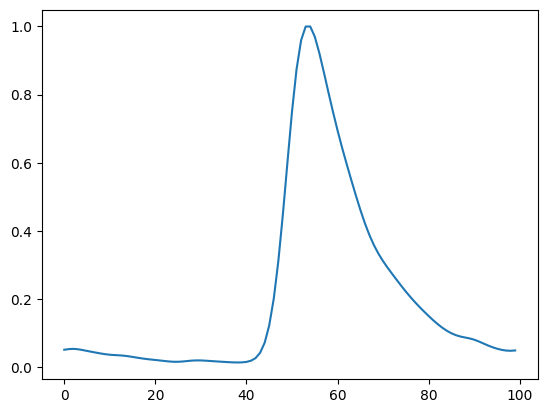

In [31]:
%matplotlib inline
plt.plot(
    weights.rot.to.rot[weights.rot.to.rot.shape[0]//2][::-1]
)

In [32]:
class HDPlotter(ArtistCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        cache['hd_ax_1'] = cache.fig.add_subplot(cache.gc[6:8, :])
        cache['hd_ax_2'] = cache.fig.add_subplot(cache.gc[8:10, :])
        cache['hd_ax_3'] = cache.fig.add_subplot(cache.gc[10:, :])
        self.requires = [
            'hd_ax_1',
            'hd_ax_2',
            'hd_ax_3',
            'fig',
            'rates',
            'weights',
            'activity',
            'k_ratio',
            'movement_params',
            # 'hd_attractors'
        ]
        super().set_cache(cache, on_repeat)

    def on_plot(self):
        self.hd_ax_1.plot(
            self.rates.hd_ring1,
            '.'
        )
        self.hd_ax_2.plot(
            self.rates.hd_ring2,
            '.'
        )
        # rot_weights = None
        # target = self.movement_params.rotate_target
        # direction = self.movement_params.direction
        # rotation = np.zeros_like(self.rates.hd)

        # if target is not None:
        #     angle_to_target = target

        #     diff = angle_to_target - direction
        #     if diff > np.pi:
        #         diff -= 2*np.pi
        #     elif diff < -np.pi:
        #         diff += 2*np.pi

        #     if np.isclose(diff, 0, atol=0.05):
        #         rotation = np.zeros_like(self.rates.hd)
        #     elif diff < 0:
        #         rotation = (self.hd_attractors.cw_rotation(self.rates.hd.T)@self.rates.hd.T).T
        #     elif diff > 0:
        #         rotation = (self.hd_attractors.ccw_rotation(self.rates.hd.T)@self.rates.hd.T).T

        # if rot_weights is None:
        #     rot_weights = np.zeros_like(self.weights.rot.to.rot)

        # self.hd_ax_1.plot(self.rates.hd)
        # self.hd_ax_2.plot((self.hd_attractors.hd_attractor(self.rates.hd.T)@self.rates.hd.T).T)
        # self.hd_ax_3.plot(rotation)

    def on_clean(self):
        self.hd_ax_1.clear()
        self.hd_ax_1.set_ylim(0, 1)
        self.hd_ax_2.clear()
        self.hd_ax_2.set_ylim(0, 1)
        self.hd_ax_3.clear()

In [33]:
from typing import Literal, Mapping


class RotationCallback(BaseCallback):
    def __init__(
        self,
        rotation_speed: float
    ):
        super().__init__()
        self.rotation_speed = rotation_speed

    def set_cache(self, cache: Mapping, on_repeat: Literal['raise'] | Literal['ignore'] | Literal['overwrite'] = 'raise'):
        self.requires = [
            'movement_params',
        ]
        super().set_cache(cache, on_repeat)

    def on_step_begin(self, step: int):
        if self.movement_params.direction is not None and\
            self.movement_params.rotate_target is not None:
            if self.movement_params.direction != self.movement_params.rotate_target:
                diff = self.movement_params.rotate_target - self.movement_params.direction
                if diff > np.pi:
                    diff -= 2*np.pi
                elif diff < -np.pi:
                    diff += 2*np.pi

                if np.isclose(diff, 0, atol=0.05):
                    self.movement_params.rotate_target = self.movement_params.direction
                elif diff < 0:
                    self.movement_params.direction -= self.rotation_speed
                elif diff > 0:
                    self.movement_params.direction += self.rotation_speed

                self.movement_params.direction %= 2*np.pi

In [34]:
class RotSpeedPlotter(ArtistCallback):
    def __init__(self, coords: tuple[float, float], alpha = .5):
        super().__init__()
        self.coords = coords
        self.direction_prev = None
        self.alpha = alpha
        self.ewma_prev = None

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        cache['rot_ax'] = cache.fig.add_subplot(cache.gc[1, 1])
        self.requires = [
            'rot_ax',
            'dynamics_params',
            'movement_params',
            'activity',
            'hd_attractors',
            'rates'
        ]
        super().set_cache(cache, on_repeat)

    def plot(self):

        pop = (self.hd_attractors.hd_attractor(self.rates.hd.T)@self.rates.hd.T).T
        ind = np.where(pop == pop.max())[0][0]

        if self.direction_prev is None:
            diff = 0
        else:
            diff = abs(self.direction_prev - ind)

        self.direction_prev = ind

        instant_rotation_speed = diff/len(self.rates.hd)

        if self.ewma_prev is None:
            self.previous_ewma = instant_rotation_speed
        else:
            self.previous_ewma = (self.alpha * instant_rotation_speed) + ((1 - self.alpha) * self.previous_ewma)


        self.rot_ax.text(
            *self.coords,
            f'Speed: {self.previous_ewma : .2f} s'
        )

    def on_plot(self):
        self.plot()

    def on_clean(self):
        self.rot_ax.clear()
        self.rot_ax.set_axis_off()

In [35]:
connectivity.hd_ring2.to.hd_ring2['tau']

0.02

In [36]:
2*(random_like(rates.hd_ring1) - .5).min(), 2*(random_like(rates.hd_ring1) - .5).max()

(-0.9793331855666378, 0.9844526685310653)

In [37]:
connectivity.hd_ring1.to.hd_ring1['beta'], connectivity.hd_ring1.to.hd_ring1['alpha']

(0.1, 5)

2024-06-07 15:49:33 - DEBUG - Loaded backend inline version unknown.


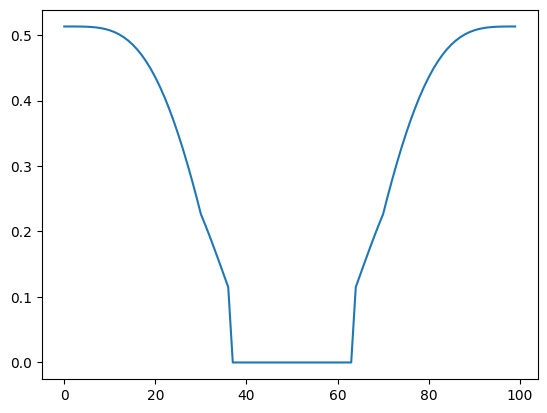

In [38]:
%matplotlib inline
ker = (get_gaussian_kernel(
        100,
        center=0.2,
        sigma=0.2
    ) + get_gaussian_kernel(
        100,
        center=0.8,
        sigma=0.2
    ) - .7)
ker[ker < .1] = 0
plt.plot(
    ker
)

In [39]:
import random
random.seed(10)

NHD  = 101
NIN  = NHD
amp  = 1
sig  = 1.1
sig  = NHD*sig/(2*np.pi)
sig2 = 1.1
sig2 = NHD*sig2/(2*np.pi)

offset = 34;  # 130 for 360neurons, 36 for 100 neurons % how far the inhibition is offset\n",

HD2INHwts = np.zeros((NHD,NHD))
INH2HDwtsCW = np.zeros((NHD,NHD))
INH2HDwtsCCW = np.zeros((NHD,NHD))

x = np.arange(NHD)
x0 = np.floor(NHD/2)+1

Gaussian    = amp*np.exp(-((x-x0)/sig)**2)
Gaussian2   = amp*np.exp(-((x-x0)/sig2)**2)
GaussianCW  = np.roll(Gaussian.T,-offset)
GaussianCCW = np.roll(Gaussian.T,offset)

shiftby = np.floor(NHD/2)
shiftby = shiftby.astype(int)
Gaussian2 = np.roll(Gaussian2,-shiftby)

GaussianCW = np.roll(GaussianCW,-shiftby)
GaussianCCW = np.roll(GaussianCCW,-shiftby)

for x0 in range(NHD):

    HD2INHwts[:,x0] = Gaussian2
    Gaussian2 = np.roll(Gaussian2,1)

    INH2HDwtsCW[:,x0] = GaussianCW
    GaussianCW = np.roll(GaussianCW,1)

    INH2HDwtsCCW[:,x0] = GaussianCCW
    GaussianCCW = np.roll(GaussianCCW,1)

dt     = 0.001
step   = 1
Nsteps = 3000
tau    = 0.02
beta   = 0.1
alpha  = 30

act  = np.zeros((NHD,1),float)
I    = np.zeros((NHD,1),float)
rate = np.zeros((NHD,1),float)

act_IN  = np.zeros((NIN,1),float)
rate_IN = np.zeros((NIN,1),float)

K   = -act
act = act + dt/tau*K

K_IN   = -act_IN
act_IN = act_IN + dt/tau*K_IN

baseIN2HDphiCW  = -8
baseIN2HDphiCCW = -8
baseHD2INphi    = 3

2024-06-07 16:04:34 - DEBUG - Loaded backend inline version unknown.


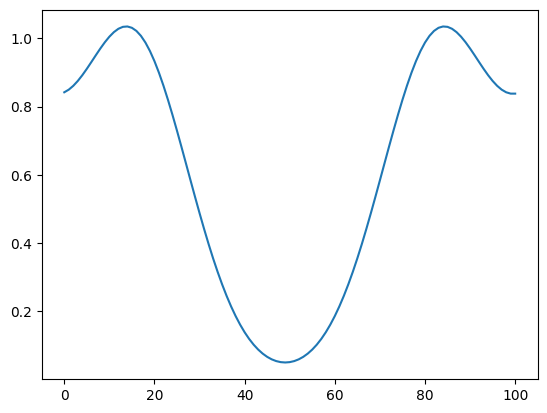

In [59]:
%matplotlib inline
# plt.plot(HD2INHwts[50, :])
plt.plot((INH2HDwtsCW + INH2HDwtsCCW)[50, :])

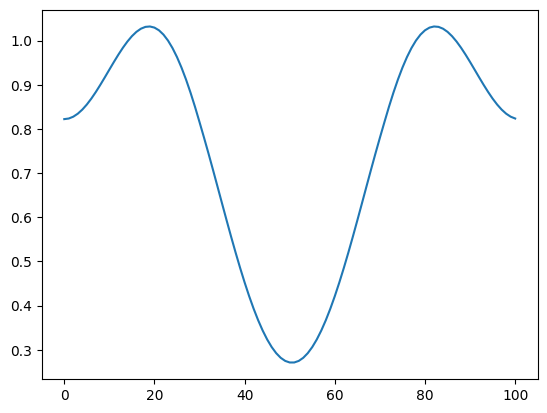

In [64]:
plt.plot(
    get_gaussian_kernel(101, center=0.2, sigma=0.15) +
    get_gaussian_kernel(101, center=0.8, sigma=0.15)
)

In [79]:
from bbtoolkit.dynamics import DynamicsManager
from bbtoolkit.dynamics.callbacks.viz import PlottingCallback
from bbtoolkit.models.bb.callbacks import TimerCallback
from bbtoolkit.models.bb.structures import ClickParameters, DynamicParameters
from bbtoolkit.structures import DotDict
from bbtoolkit.dynamics.callbacks.movement import MovementParameters

%matplotlib qt

dt = .002

direction = np.pi/2

cache = DotDict()
cache['dynamics_params'] = DynamicParameters(dt, None)
cache['click_params'] = ClickParameters()
cache['movement_params'] = MovementParameters(direction=np.pi/2)
cache['weights'] = weights.copy()
cache['activity'] = activity.copy()
cache['rates'] = rates.copy()
cache['k_ratio'] = k_ratio.copy()
cache['connectivity'] = connectivity.copy()
cache.connectivity.hd_ring1.to.hd_ring1['phi'] = 15
cache.connectivity.hd_ring2.to.hd_ring2['phi'] = 15
# cache.rates.hd_ring1 = rate.copy()[:100]
# cache.rates.hd_ring2 = rate_IN.copy()[:100]
# cache.k_ratio.hd_ring1 = K.copy()[:100]
# cache.k_ratio.hd_ring2 = K_IN.copy()[:100]
# cache.activity.hd_ring1 = act.copy()[:100]
# cache.activity.hd_ring2 = act_IN.copy()[:100]


dynamics = DynamicsManager(
    dt,
    callbacks=[
        RotationCallback(np.pi/500),
        # HDCallback(
        #     RingAttractor(
        #         # (
        #         #     get_gaussian_kernel(n_hd_neurons, .025, amplitude=1) - .4,
        #         #     2*(get_gaussian_kernel(
        #         #         100,
        #         #         center=0.2,
        #         #         sigma=0.2
        #         #     ) + get_gaussian_kernel(
        #         #         100,
        #         #         center=0.8,
        #         #         sigma=0.2
        #         #     ) - .7),
        #         # )
        #         (
        #             get_gaussian_kernel(n_hd_neurons, .1, amplitude=1),
        #             # -1* (get_gaussian_kernel(
        #             #     100,
        #             #     center=0.2,
        #             #     sigma=0.2
        #             # ) + get_gaussian_kernel(
        #             #     100,
        #             #     center=0.8,
        #             #     sigma=0.2
        #             # ) - .7),
        #             -ker
        #         )
        #     ),
        # ),
        # HDCallback(
        #     weights_inh=HD2INHwts,
        #     weights_cw=INH2HDwtsCW,
        #     weights_ccw=INH2HDwtsCCW
        # ),
        HDCallback(
            RingAttractor(
                (
                    # (HD2INHwts[50, :])[None, :],
                    get_gaussian_kernel(100, center=0.5, sigma=0.1)[None, :],
                    # ((INH2HDwtsCW + INH2HDwtsCCW)[50, :])[None, :]
                    (get_gaussian_kernel(100, center=0.2, sigma=0.15) +
                    get_gaussian_kernel(100, center=0.8, sigma=0.15))[None, :]
                )
            )
        ),
        TimerCallback(),
        PlottingCallback(
            [
                PolarCirclePlotter(),
                TimerPlotter((0, 0)),
                # RotSpeedPlotter((0, 0), 0.0000001),
                HDPlotter(),
                MouseEventCallback(),
            ],
            update_rate=5,
            fig_kwargs=dict(figsize=(10, 10)),
            gc_kwargs=dict(nrows=12, ncols=12)
        )
    ],
    cache=cache
)


for _ in dynamics(True):
    print('out: ', _)

2024-06-07 16:11:34 - DEBUG - Loaded backend qtagg version 6.7.0.


out:  (None, None, None, None)


KeyboardInterrupt: 

2024-06-07 15:12:16 - DEBUG - Loaded backend inline version unknown.
2024-06-07 15:12:16 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7173aac81c40>
2024-06-07 15:12:16 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7173b4b9d370>


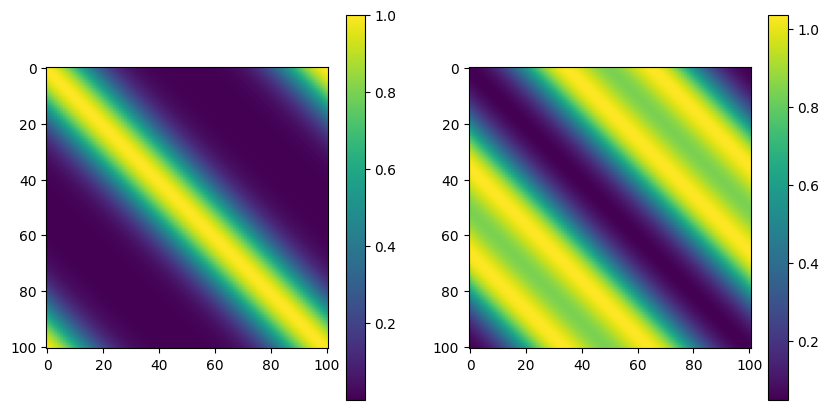

In [ ]:
inh, cw = dynamics.callbacks[1].weights_inh, dynamics.callbacks[1].weights_cw + dynamics.callbacks[1].weights_ccw

%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
c = ax1.imshow(inh)
plt.colorbar(c)
c = ax2.imshow(cw)
plt.colorbar(c)

In [ ]:
self = dynamics.callbacks[1]
((self.weights_inh)@self.rates.hd_ring2).T

array([[ 1.53718626,  1.7730494 ,  2.03408976,  2.32102212,  2.63422739,
         2.97369854,  3.33899017,  3.72917375,  4.14280075,  4.57787567,
         5.03184109,  5.50157636,  5.98341138,  6.47315637,  6.96614811,
         7.4573126 ,  7.94124328,  8.41229347,  8.86468118,  9.29260354,
         9.690358  , 10.05246669, 10.37380036, 10.64969791, 10.87607778,
        11.04953742, 11.16743757, 11.22796844, 11.23019544, 11.17408301,
        11.06049552, 10.89117537, 10.66869898, 10.39641216, 10.07834729,
         9.71912481,  9.32384275,  8.89795757,  8.44716044,  7.97725267,
         7.49402404,  7.00313765,  6.51002416,  6.0197882 ,  5.53712888,
         5.06627587,  4.61094178,  4.17429106,  3.75892503,  3.36688205,
         2.99965153,  2.65820004,  2.34300752,  2.05411166,  1.79115798,
         1.55345373,  1.3400236 ,  1.14966516,  0.98100275,  0.83253819,
         0.7026975 ,  0.58987277,  0.49245865,  0.40888276,  0.337632  ,
         0.27727271,  0.22646403,  0.18396912,  0.1

In [ ]:
state = self.attractor((self.k_ratio.hd_ring1.T, self.k_ratio.hd_ring2.T))
w1, w2 = state.values()

In [ ]:
print(w1)

[[ 26.68511661  27.10572637  27.43097429  27.65176297  27.76030958
   27.74880775  27.61096627  27.34141293  26.93548342  26.3903551
   25.70457788  24.87836107  23.91262614  22.81069618  21.57680417
   20.21694012  18.7386034   17.15055117  15.46260463  13.68572584
   11.83188266   9.91390076   7.94508756   5.93943366   3.91093776
    1.87409217  -0.15666455  -2.1671628   -4.14362522  -6.07252727
   -7.94085359  -9.73693311 -11.4488162  -13.06605323 -14.579207
  -15.97976107 -17.25986412 -18.41318055 -19.43382976 -20.3175563
  -21.06121341 -21.66275123 -22.12097948 -22.43628267 -22.60932306
  -22.64271071 -22.53926366 -22.30320638 -21.93962882 -21.45452074
  -20.8543928  -20.14667426 -19.33932605 -18.44083577 -17.46032432
  -16.40733496 -15.2917571  -14.12305788 -12.91167693 -11.66756893
  -10.39998051  -9.1190152   -7.83330489  -6.55192613  -5.28249577
   -4.03265131  -2.80851231  -1.61544837  -0.45808693   0.66045765
    1.73799816   2.77364665   3.76769718   4.72102246   5.63589928

In [ ]:
attr = self.attractor
w1, w2 = attr.get_weights()
# r1, r2 = np.random.random(attr.kernels[0].shape).T, np.random.random(attr.kernels[1].shape).T
r1, r2 = self.rates.hd_ring1, self.rates.hd_ring2

In [ ]:
w1[0, :, 0, :]@r1

array([[ 2.89199597],
       [ 3.22993286],
       [ 3.59310686],
       [ 3.98095851],
       [ 4.39250519],
       [ 4.82631342],
       [ 5.28047853],
       [ 5.75261364],
       [ 6.23984957],
       [ 6.7388458 ],
       [ 7.24581398],
       [ 7.75655403],
       [ 8.26650253],
       [ 8.77079333],
       [ 9.26432949],
       [ 9.74186501],
       [10.19809473],
       [10.62775022],
       [11.02569984],
       [11.38704953],
       [11.70724226],
       [11.98215302],
       [12.20817694],
       [12.38230718],
       [12.50220147],
       [12.56623391],
       [12.57353166],
       [12.52399443],
       [12.41829688],
       [12.25787326],
       [12.04488534],
       [11.78217402],
       [11.4731968 ],
       [11.12195232],
       [10.73289474],
       [10.31084036],
       [ 9.86086915],
       [ 9.38822375],
       [ 8.89820938],
       [ 8.39609654],
       [ 7.88702922],
       [ 7.37594097],
       [ 6.86748043],
       [ 6.36594769],
       [ 5.87524252],
       [ 5

In [ ]:
np.all(
    self.weights_inh.T == w1[0, :, 0, :]
)

True

In [ ]:
self.weights_inh

array([[0.99680672, 0.98728792, 0.97162483, ..., 0.98728792, 0.99680672,
        1.        ],
       [1.        , 0.99680672, 0.98728792, ..., 0.97162483, 0.98728792,
        0.99680672],
       [0.99680672, 1.        , 0.99680672, ..., 0.95011309, 0.97162483,
        0.98728792],
       ...,
       [0.95011309, 0.92315347, 0.8912395 , ..., 0.99680672, 0.98728792,
        0.97162483],
       [0.97162483, 0.95011309, 0.92315347, ..., 1.        , 0.99680672,
        0.98728792],
       [0.98728792, 0.97162483, 0.95011309, ..., 0.99680672, 1.        ,
        0.99680672]])

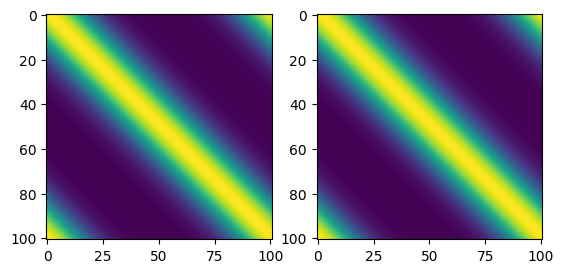

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(self.weights_inh.T)
ax2.imshow(w1[0, :, 0, :])


In [ ]:
np.all(
    self.weights_inh.T == w1[0, :, 0, :]
)

True

In [ ]:
(self.weights_inh.T@r1).T

array([[ 2.89199597,  3.22993286,  3.59310686,  3.98095851,  4.39250519,
         4.82631342,  5.28047853,  5.75261364,  6.23984957,  6.7388458 ,
         7.24581398,  7.75655403,  8.26650253,  8.77079333,  9.26432949,
         9.74186501, 10.19809473, 10.62775022, 11.02569984, 11.38704953,
        11.70724226, 11.98215302, 12.20817694, 12.38230718, 12.50220147,
        12.56623391, 12.57353166, 12.52399443, 12.41829688, 12.25787326,
        12.04488534, 11.78217402, 11.4731968 , 11.12195232, 10.73289474,
        10.31084036,  9.86086915,  9.38822375,  8.89820938,  8.39609654,
         7.88702922,  7.37594097,  6.86748043,  6.36594769,  5.87524252,
         5.39882509,  4.93968932,  4.50034844,  4.08283251,  3.68869653,
         3.31903836,  2.97452482,  2.65542491,  2.36164769,  2.09278456,
         1.8481526 ,  1.62684113,  1.427755  ,  1.24965766,  1.09121257,
         0.95102057,  0.82765239,  0.71968237,  0.62570914,  0.54438279,
         0.47441725,  0.41461184,  0.36385557,  0.3

In [ ]:
(w1[0, :, 0, :]@r1).T

array([[ 2.89199597,  3.22993286,  3.59310686,  3.98095851,  4.39250519,
         4.82631342,  5.28047853,  5.75261364,  6.23984957,  6.7388458 ,
         7.24581398,  7.75655403,  8.26650253,  8.77079333,  9.26432949,
         9.74186501, 10.19809473, 10.62775022, 11.02569984, 11.38704953,
        11.70724226, 11.98215302, 12.20817694, 12.38230718, 12.50220147,
        12.56623391, 12.57353166, 12.52399443, 12.41829688, 12.25787326,
        12.04488534, 11.78217402, 11.4731968 , 11.12195232, 10.73289474,
        10.31084036,  9.86086915,  9.38822375,  8.89820938,  8.39609654,
         7.88702922,  7.37594097,  6.86748043,  6.36594769,  5.87524252,
         5.39882509,  4.93968932,  4.50034844,  4.08283251,  3.68869653,
         3.31903836,  2.97452482,  2.65542491,  2.36164769,  2.09278456,
         1.8481526 ,  1.62684113,  1.427755  ,  1.24965766,  1.09121257,
         0.95102057,  0.82765239,  0.71968237,  0.62570914,  0.54438279,
         0.47441725,  0.41461184,  0.36385557,  0.3

In [ ]:
attr((r1.T, r2.T)).values()[0]

array([[ 2.89199597,  3.22993286,  3.59310686,  3.98095851,  4.39250519,
         4.82631342,  5.28047853,  5.75261364,  6.23984957,  6.7388458 ,
         7.24581398,  7.75655403,  8.26650253,  8.77079333,  9.26432949,
         9.74186501, 10.19809473, 10.62775022, 11.02569984, 11.38704953,
        11.70724226, 11.98215302, 12.20817694, 12.38230718, 12.50220147,
        12.56623391, 12.57353166, 12.52399443, 12.41829688, 12.25787326,
        12.04488534, 11.78217402, 11.4731968 , 11.12195232, 10.73289474,
        10.31084036,  9.86086915,  9.38822375,  8.89820938,  8.39609654,
         7.88702922,  7.37594097,  6.86748043,  6.36594769,  5.87524252,
         5.39882509,  4.93968932,  4.50034844,  4.08283251,  3.68869653,
         3.31903836,  2.97452482,  2.65542491,  2.36164769,  2.09278456,
         1.8481526 ,  1.62684113,  1.427755  ,  1.24965766,  1.09121257,
         0.95102057,  0.82765239,  0.71968237,  0.62570914,  0.54438279,
         0.47441725,  0.41461184,  0.36385557,  0.3